# Examine cast data from APL-SURP cruise using a specialized package

*Created for the University of Washington Applied Physics Laboratory's Summer Undergraduate Research Program (SURP) 2025.*

This notebook demonstrates the use of the [`ctd` open-source package](https://pyoceans.github.io/python-ctd/) to read SeaBird CTD `.cnv` files and the [`folium` open-source package](https://python-visualization.github.io/folium/) to create interactive maps of cast locations using information read from the cast files.

This notebook builds off the [Quick introduction notebook](https://pyoceans.github.io/python-ctd/quick_intro-output.html) found on the `ctd` website.

See the [APL-SURP Day 2 notebook](https://uw-apl-surp.github.io/aplsurp-python/lessons/APL_SURP_Python_course_Notebook_2.html#part-4-loading-tabular-data) to compare the use of the `ctd` package with operations based solely on the `Pandas` package. But note that the CTD data file used in that notebook have a somewhat different configuration.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

We'll use the `pathlib` package (part of the Python Standard Library) to handle file paths more seamlessly via `pathlib.Path` objects. `data_dir` is the base directory for the data files. The data files are found on our GitHub repository, under [site/notebooks/data/aplsurp_cruises_cnvs_2024](https://github.com/UW-APL-SURP/aplsurp-python/tree/main/site/notebooks/data/aplsurp_cruises_cnvs_2024)

In [2]:
data_dir = Path("./data/aplsurp_cruises_cnvs_2024")

## Read a `.cnv` data file

We'll use the Python [`ctd` package](https://pyoceans.github.io/python-ctd/) to read a `.cnv` file for one cast, exported directly by the [SeaBird](https://www.seabird.com/) software used for managing these data. This file includes data from all sensors (SeaBird CTD and other sensors) as well as metadata about the cruise and the cast, such as location (latitude, longitude and station name), time, sensor names and calibration, etc. The `ctd` package contains custom functionality for data pre-processing and plotting ocean vertical profiles.

In [3]:
import ctd

In [4]:
cast = ctd.from_cnv(data_dir / "20240718_CTD05_p28.cnv")

type(cast)

pandas.core.frame.DataFrame

The `ctd.from_cnv` function reads the `.cnv` file and returns a `Pandas` `DataFrame` with custom properties and functions. This DataFrame, `cast`, contains all "CTD" data collected by sensors during the cast, together with metadata either from each sensor or added to the system software by the operators. 

Note that the data goes well beyond conductivity, temperature and depth (pressure), since other sensors are also present.

## Examine information about the cast

Let's look at the first 5 rows and the DataFrame `.info()`, to get a feel for the data:

In [5]:
cast.head()

,t090C,sal00,c0S/m,sbox0Mm/Kg,CStarTr0,flECO-AFL,ph,par,flag
Pressure [dbar],,,,,,,,,
6.543,14.0140,30.7695,3.737626,225.061,68.6557,6.8175,8.034,137.86,False
6.558,14.0138,30.7709,3.737760,224.907,68.9782,6.8175,8.029,137.86,False
6.543,14.0135,30.7719,3.737836,224.743,69.0319,6.8175,8.034,138.65,False
6.558,14.0134,30.7718,3.737811,224.720,69.0050,6.8175,8.034,139.04,False
6.543,14.0128,30.7725,3.737842,224.852,68.9782,6.8175,8.029,139.04,False


In [6]:
cast.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26928 entries, 6.543 to 1.896
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   t090C       26928 non-null  float64
 1   sal00       26928 non-null  float64
 2   c0S/m       26928 non-null  float64
 3   sbox0Mm/Kg  26928 non-null  float64
 4   CStarTr0    26928 non-null  float64
 5   flECO-AFL   26928 non-null  float64
 6   ph          26928 non-null  float64
 7   par         26928 non-null  float64
 8   flag        26928 non-null  bool   
dtypes: bool(1), float64(8)
memory usage: 1.9 MB


The index and columns in this DataFrame show the variables that are read: pressure (the index), temperature, salinity, conductivity, dissolved oxygen concentration, beam transmission, fluorescence, pH, photosynthetically active radiation, and a data quality flag.

The `ctd` package parses and stores **file metadata** (from the `.cnv` header section) in the `_metadata` property of the DataFrame, for convenient access. This property is a [Python dictionary](https://learn-python.adamemery.dev/data_structures#dictionary). Let's look at the raw content.

In [7]:
cast._metadata

{'name': 'C:\\Data\\RC0122ctd\\20240718_CTD05_p28',
 'header': '* Sea-Bird SBE 9 Data File:\n* FileName = C:\\Data\\RC0122ctd\\20240718_CTD05_p28.hex\n* Software Version Seasave V 7.26.7.107\n* Temperature SN = 1121\n* Conductivity SN = 2881\n* Number of Bytes Per Scan = 31\n* Number of Voltage Words = 4\n* Number of Scans Averaged by the Deck Unit = 1\n* System UpLoad Time = Jul 18 2024 08:54:01\n* NMEA Latitude = 47 42.80 N\n* NMEA Longitude = 122 25.16 W\n* NMEA UTC (Time) = Jul 18 2024  15:54:00\n* Store Lat/Lon Data = Append to Every Scan\n* SBE 11plus V 5.2\n* number of scans to average = 1\n* pressure baud rate = 9600\n* NMEA baud rate = 4800\n* GPIB address = 1\n* advance primary conductivity  0.073 seconds\n* advance secondary conductivity  0.073 seconds\n* delete word 3 from scan\n* delete word 4 from scan\n* autorun on power up is disabled\n* S>\n** Ship: R/V Rachel Carson\n** Cruise ID: RC0121\n** Tech: Jalickee\n** Chief Scientist: Boyar\n** Station: p28\n** Cast:  05\n* S

Let's look at the metadata more closely by first examining the dictionary "keys", then some of the individual items:

In [8]:
metadata = cast._metadata

metadata.keys()

dict_keys(['name', 'header', 'config', 'names', 'skiprows', 'time', 'lon', 'lat'])

We'll store cast time, latitude and longitude in variables for reuse later in the notebook

In [9]:
metadata['time'], metadata['lat'], metadata['lon']

(datetime.datetime(2024, 7, 18, 22, 54, tzinfo=datetime.timezone.utc),
 np.float64(47.71333333333333),
 np.float64(-122.41933333333333))

In [10]:
print(metadata['header'])

* Sea-Bird SBE 9 Data File:
* FileName = C:\Data\RC0122ctd\20240718_CTD05_p28.hex
* Software Version Seasave V 7.26.7.107
* Temperature SN = 1121
* Conductivity SN = 2881
* Number of Bytes Per Scan = 31
* Number of Voltage Words = 4
* Number of Scans Averaged by the Deck Unit = 1
* System UpLoad Time = Jul 18 2024 08:54:01
* NMEA Latitude = 47 42.80 N
* NMEA Longitude = 122 25.16 W
* NMEA UTC (Time) = Jul 18 2024  15:54:00
* Store Lat/Lon Data = Append to Every Scan
* SBE 11plus V 5.2
* number of scans to average = 1
* pressure baud rate = 9600
* NMEA baud rate = 4800
* GPIB address = 1
* advance primary conductivity  0.073 seconds
* advance secondary conductivity  0.073 seconds
* delete word 3 from scan
* delete word 4 from scan
* autorun on power up is disabled
* S>
** Ship: R/V Rachel Carson
** Cruise ID: RC0121
** Tech: Jalickee
** Chief Scientist: Boyar
** Station: p28
** Cast:  05
* System UTC = Jul 18 2024 15:54:01
*END*


In [11]:
print(metadata['config'])

# nquan = 10
# nvalues = 26928
# units = specified
# name 0 = depSM: Depth [salt water, m]
# name 1 = t090C: Temperature [ITS-90, deg C]
# name 2 = sal00: Salinity, Practical [PSU]
# name 3 = c0S/m: Conductivity [S/m]
# name 4 = sbox0Mm/Kg: Oxygen, SBE 43 [umol/kg]
# name 5 = CStarTr0: Beam Transmission, WET Labs C-Star [%]
# name 6 = flECO-AFL: Fluorescence, WET Labs ECO-AFL/FL [mg/m^3]
# name 7 = ph: pH
# name 8 = par: PAR/Irradiance, Biospherical/Licor
# name 9 = flag:  0.000e+00
# span 0 =      0.619,    180.351
# span 1 =    11.1966,    16.1026
# span 2 =    29.2562,    30.7725
# span 3 =   3.442453,   3.755137
# span 4 =    186.942,    411.365
# span 5 =    61.9648,    93.5652
# span 6 =     0.0776,     8.7223
# span 7 =      7.539,      8.284
# span 8 = 1.0000e-12, 4.0607e+03
# span 9 = 0.0000e+00, 0.0000e+00
# interval = seconds: 0.0416667
# start_time = Jul 18 2024 15:54:00 [NMEA time, header]
# bad_flag = -9.990e-29
# <Sensors count="11" >
#   <sensor Channel="1" >
#     <!--

## Extract and visualize downcast data only

The data file contains both "downcast" and "upcast" data, but in this notebook **we'll focus on the downcast data.** The `ctd` package added a `.split()` function to the `cast` DataFrame that separates the data into downcast and upcast:

In [12]:
# Separate the data into downcast and upcast
down_cast_df, up_cast_df = cast.split()

`cast.info()` told us there are 26,928 sets of observations in the file. After splitting and selecting only the downcast, we're left with 14,921

In [13]:
len(down_cast_df)

14921

We can use the `ctd` `plot_cast` function to plot depth profiles of one or more variables. This function has been added to the DataFrame. `plot_cast` uses plot settings that are tuned to how we typically would visualize depth profiles, so we can get a user-friendly plot very easily.

First, let's do a simple plot of temperature.

<Axes: xlabel='t090C', ylabel='Pressure [dbar]'>

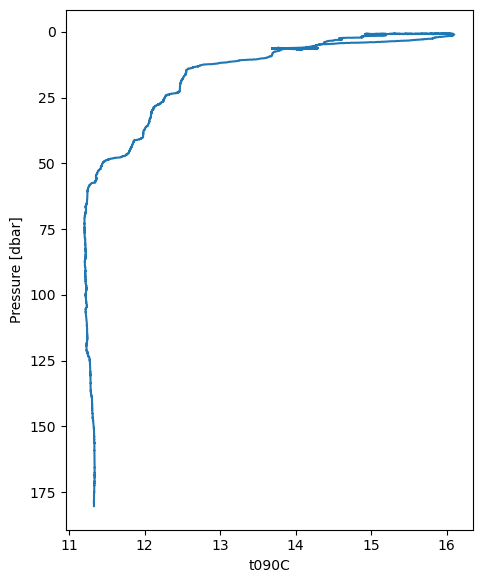

In [14]:
down_cast_df["t090C"].plot_cast()

We can also use `plot_cast` to plot depth profiles of two variables on different axes by using the `ax` and `secondary_y` arguments. Note that the raw data is somewhat "noisy".

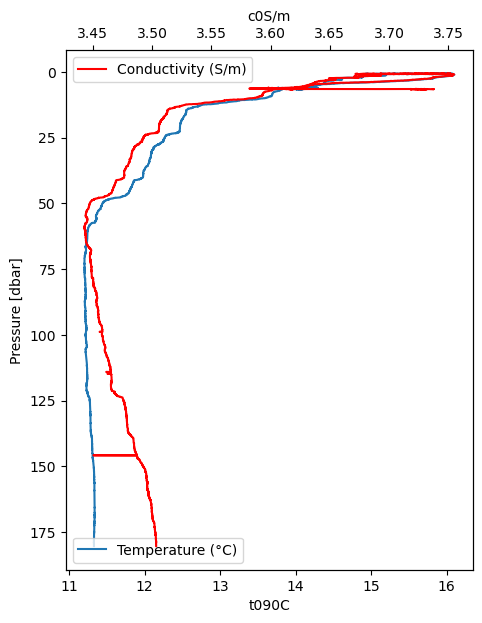

In [15]:
ax0 = down_cast_df["t090C"].plot_cast(label="Temperature (°C)")
ax1 = down_cast_df["c0S/m"].plot_cast(
    ax=ax0,
    label="Conductivity (S/m)",
    color="red",
    secondary_y=True,
)

ax0.legend(loc="lower left")
ax1.legend(loc="upper left");

Here are two more variables, both related to light. Fluorescence reflects chlorophyll concentration.

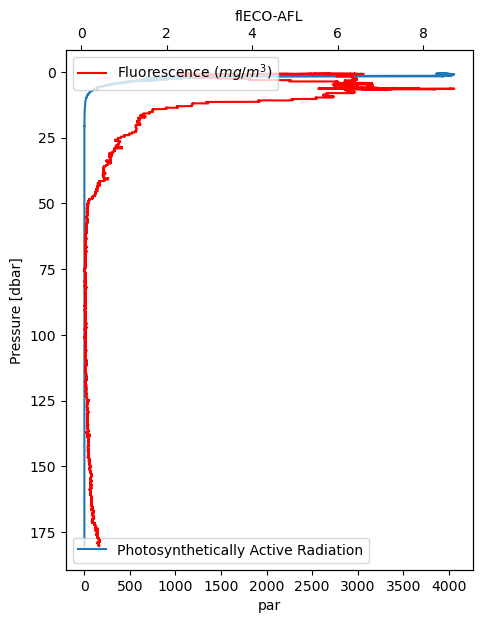

In [16]:
ax0 = down_cast_df["par"].plot_cast(
    label="Photosynthetically Active Radiation")
ax1 = down_cast_df["flECO-AFL"].plot_cast(
    ax=ax0,
    label="Fluorescence ($mg/m^3$)",
    color="red",
    secondary_y=True,
)

ax0.legend(loc="lower left")
ax1.legend(loc="upper left");

## Pre-process temperature and conductivity

We've seen that the raw data are somewhat noisy; they contain wiggles and unexpected jumps. Let's use functions provided by the `ctd` package to perform data cleaning and pre-processing steps that are typically applied to such data. Note how the functions are "chained" to apply in a sequence, one after the other. 

Here, we'll retain only temperature, conductivity and pressure (pressure is from the DataFrame index).

In [17]:
proc = (
    down_cast_df[["t090C", "c0S/m"]]
    # Remove all data above the water line
    .remove_above_water()
    # Remove all the data above a certain index value, where index can be pressure or depth
    # (it can be unreliable)
    .remove_up_to(idx=4)
    # Remove data spikes
    .despike(n1=2, n2=20, block=100)
    # Apply "low-pass" filter, to remove high-frequency wiggles
    .lp_filter()
    # Remove pressure reversals from the index
    .press_check()
    # Interpolate gaps (this is a Pandas function)
    .interpolate()
    # Bin-average the index (usually pressure) to a given interval (here, 1 meter)
    .bindata(delta=1, method="interpolate")
    # Smooth the data using a window with the requested size
    .smooth(window_len=21, window="hanning")
)

proc.head()

,t090C,c0S/m
7.0,13.861522,3.605726
8.0,13.695658,3.593835
9.0,13.532086,3.582112
10.0,13.374312,3.570814
11.0,13.225274,3.560157


Now let's compare the raw vs pre-processed temperature:

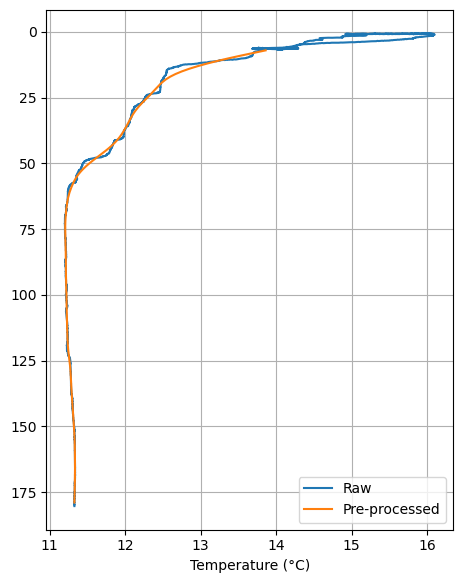

In [18]:
ax = down_cast_df["t090C"].plot_cast(label="Raw")
proc["t090C"].plot_cast(ax=ax, label="Pre-processed")

ax.grid(True)
ax.legend(loc="lower right")
plt.xlabel("Temperature (°C)");

## Map the locations of all casts

The [`folium` package](https://python-visualization.github.io/folium/) provides a convenient tool for creating interactive maps. First we'll map the location of the cast we've been examining.

In [19]:
import folium

After initializing a `folium` map, we add a "marker" with the information about the cast and some plotting configurations

In [20]:
castmap = folium.Map()

folium.Marker(
    location=[metadata['lat'], metadata['lon']],
    icon=folium.Icon(color='red'),
    tooltip="Cruise CTD cast",
    popup=f"Cruise CTD, {metadata['time']}"
).add_to(castmap)

# Set the map extent (bounds) to the extent of the sites
castmap.fit_bounds(castmap.get_bounds())

# Now generate and disply the interactive map
castmap

Because the map shows just one point, it's zoomed in very closely and the background shows just water. This is an interactive map, so zoom out a few times until you see the Seattle coastline.

## Read and map all casts

Finally, let's create a map with **all** the casts. We'll extract information from the metadata as we did before, but this time we'll handle even more information in order to generate more extensive (and useful) tooltip and popup information.

`get_header_element` is a helper function to extract specific metadata values. The next code block loops through all cast `.cnv` files in the data directory using the `pathlib.Path.glob` function, reads each cast, extracts the desired metadata, and compiles the `casts_metadata` list for use in the `folium` mapping code.

In [21]:
def get_header_element(element_name, metadata):
    """
    Extract the value for the metadata element "element_name"
    from the metadata "header" section
    """
    metadata_header_aslist = metadata['header'].split('\n')
    for e in metadata_header_aslist:
        if element_name in e:
            element_value = e.split(":")[-1].strip()
            return element_value

In [22]:
casts_metadata = []
for cnv_filepath in data_dir.glob("*.cnv"):
    # Read the cast and its metadata
    cast = ctd.from_cnv(cnv_filepath)
    metadata = cast._metadata
    
    # Let's add additional info to the metadata dictionary,
    # by probing into the cast data and parsing the metadata "header" section
    metadata['depth_max'] = cast.index.max()
    for element_name in ["Cruise ID", "Station", "Cast"]:
        metadata[element_name] = get_header_element(element_name, metadata)

    # Append the metadata to the casts_metadata list
    casts_metadata.append(metadata)

In [23]:
casts_map = folium.Map(tiles='ESRI.OceanBasemap')

# This is just like the single-cast map, except we're now adding
# multiple casts (markers) and populating them with much more information
for castmd in casts_metadata:
    folium.Marker(
        location=[castmd['lat'], castmd['lon']],
        icon=folium.Icon(color='red'),
        tooltip=f"{castmd['Cruise ID']}: {castmd['Station']}-{castmd['Cast']}",
        popup=f"""Cruise {castmd['Cruise ID']}, Station {castmd['Station']},
                Cast {castmd['Cast']}, {castmd['time']:%Y-%m-%d %H:%M},
                Maximum depth {castmd['depth_max']:0.1f} m
                """,
    ).add_to(casts_map)

casts_map.fit_bounds(casts_map.get_bounds())

casts_map